In [1]:
import collections
import hashlib
import math
import os
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
from collections import defaultdict
import pandas as pd
import requests
from IPython import display
from matplotlib import pyplot as plt
from torch.utils import data
from torch import nn as nn
import torch
from Bio import SeqIO
import matplotlib_inline
import numpy as np
from torch.nn import functional as F

/home/bli/.conda/envs/Xihe/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#绘图
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
def use_svg_display():
    """使用svg格式在Jupyter中显示绘图

    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')
    #matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


In [3]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
#获取GPU
def try_all_gpus():
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]

    Defined in :numref:`sec_use_gpu`"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

In [5]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [6]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器

    Defined in :numref:`sec_linear_concise`"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [7]:
from tape import TAPETokenizer
tokenizer = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model
tokenize = tokenizer.tokenize
def load_protein_data(data_dir,batch_size,num_steps = 500):
    data,label = [],[]
    record_iter = SeqIO.parse(data_dir,'fasta')
    
    for pt_seq in record_iter:
        data.append(str(pt_seq.seq).upper())
        kind = str(pt_seq.id).split('_')[1]
        if kind == 'S':
            label.append(1)
        else:
            label.append(0)

    df = pd.DataFrame({'seq':data,'label':label})
    print(df)
    df = df.sample(frac=1)
    train_data = df.sample(frac=0.8,random_state=0,axis=0)
    test_data = df[~df.index.isin(train_data.index)]

    train_tokens = [tokenize(line) for line in list(train_data['seq'])]
    test_tokens = [tokenize(line) for line in list(test_data['seq'])]

    vocab = tokenizer.vocab
    train_features = torch.tensor([truncate_pad(
        tokenizer.convert_tokens_to_ids(line), num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(
        tokenizer.convert_tokens_to_ids(line), num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(list(train_data['label']))),
                                batch_size)
    test_iter = load_array((test_features, torch.tensor(list(test_data['label']))),
                               batch_size)
    return train_iter, test_iter, vocab

In [8]:
train_iter, test_iter, vocab = load_protein_data('../data/SOLP.fasta',batch_size=16,num_steps=500)

                                                     seq  label
0      MAISKKKRFFFDLAQDEDDAETVQEVKKVEQQLKLEPVVQPQHDLT...      1
1      MKISLSTSLFSIEQKVEYFNLNYQSLSDFSVVAKLNYTFTWYGNDF...      1
2      MDKKYDITAVLNEDSSMTAISDQFQITLDARPKHTAKGFGPLAALL...      1
3      MANSLRNVNDYDPFKYRPSYFDLEAPTESFALGKFVDAIEVKQMAL...      1
4      MNTFKETLFSLKKSNYLLNESAQILNDCVVNNNEIDERLRNSIKFA...      1
...                                                  ...    ...
17403  MKSALKKSVVSTSISLILASGMAAFAAHAADDVKLKATKTNVAFSD...      1
17404  MRTTIAVVLGAISLTSAFVFADKPDVARSANDEVSTLFFGHDDRVP...      1
17405  MRKYIPLVLFIFSWPVLCADIHGRVVRVLDGDTIEVMDSRKAVRIR...      1
17406  MSVRNIFADESHDIYTVRTHADGPDGELPLTAEMLINRPSGDLFGM...      1
17407  MKRVSQMTALAMALGLACASSWAAELAKPLTLDQLQQQNGKAIDTR...      1

[17408 rows x 2 columns]


In [9]:
for x,label in train_iter:
    print(x,label)
    break

tensor([[16, 12, 28,  ...,  0,  0,  0],
        [14,  9, 14,  ...,  0,  0,  0],
        [16, 14, 23,  ...,  0,  0,  0],
        ...,
        [16, 16, 25,  ...,  0,  0,  0],
        [15, 15, 19,  ...,  0,  0,  0],
        [17, 20, 20,  ...,  0,  0,  0]]) tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1])


In [10]:
class Tape_Classifier(nn.Module):
    
    def __init__(self, pretrain_model, config):
        super().__init__()
        self.pretrain_model = pretrain_model
        self.classifier = nn.Sequential(
                            nn.Linear(config.hidden_size1, config.hidden_size2),
                            nn.Linear(config.hidden_size2,config.num_classes))
        
    def forward(self, input_ids):
        outputs = self.pretrain_model(input_ids)
        
        output = self.classifier(outputs[1]) # batch, hidden
        return output
pretrain_model = torch.load('../model/bert-base.pt')
pretrain_model.train()
class config:
    hidden_size1 = 768
    hidden_size2 = 256
    num_classes  = 2
    
model_tape_bert = Tape_Classifier(pretrain_model,config)

In [11]:
def train_batch(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练

    Defined in :numref:`sec_image_augmentation`"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [12]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=try_all_gpus()):
    """用多GPU进行模型训练

    Defined in :numref:`sec_image_augmentation`"""
    timer, num_batches = Timer(), len(train_iter)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [13]:
'''net = model_tape_bert
devices = try_gpu()
net.to(devices)'''

'net = model_tape_bert\ndevices = try_gpu()\nnet.to(devices)'

KeyboardInterrupt: 

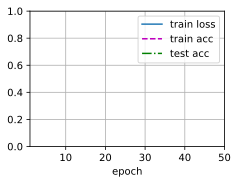

In [14]:
lr, num_epochs,wd= 0.001, 50, 0.0001
net = model_tape_bert
#net = model_BERT
net.train()
devices = try_all_gpus()
trainer = torch.optim.Adam(net.parameters(), lr=lr)#,weight_decay = wd
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

In [15]:
net

Tape_Classifier(
  (pretrain_model): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout)

In [ ]:
a = torch.rand(2)

In [ ]:
a

In [ ]:
a.unsqueeze(1)